In [ ]:
import os
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import re
import nltk
import requests
import pyLDAvis
import pyLDAvis.gensim_models

# Make sure to download nltk stopwords if not already
nltk.download("stopwords")
nltk.download("punkt")

In [ ]:
# Define paths to transcripts and tags directories
transcripts_dir = 'cleaned_transcripts/'
tags_dir = 'tags/'
csv_path = 'cleaned_results.xlsx'

# Load the CSV file and filter for "related" videos
csv_data = pd.read_excel(csv_path)
related_videos = csv_data[csv_data["related"] == "yes"]

# Load transcripts
transcripts = []
tags = []

# Process each related video based on its video_id
for video_id in related_videos["Video Id"]:
    # Construct paths based on video ID naming conventions
    transcript_file = os.path.join(transcripts_dir, f"{video_id}_captions.txt")
    tag_file = os.path.join(tags_dir, f"{video_id}.txt")
    
    # Read the transcript and tag files if they exist
    try:
        with open(transcript_file, "r", encoding="utf-8") as file:
            transcripts.append(file.read())
        with open(tag_file, "r", encoding="utf-8") as file:
            tags.append(file.read().strip())
    except FileNotFoundError:
        print(f"Files for video ID {video_id} not found, skipping.")

# Combine the filtered data into a DataFrame
data = pd.DataFrame({"video_id": related_videos["Video Id"], "tags": tags, "transcripts": transcripts})
data["text"] = data["tags"] + " " + data["transcripts"]

# Display the first few rows to verify
print(data.head())

In [3]:
# Step 2: Text Preprocessing
stop_words = set(stopwords.words("english"))

# Function to fetch stopwords from GitHub URL
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    github_stopwords = response.text.splitlines()  # Split by new lines
    return set(github_stopwords)

# GitHub URL for stopwords
github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)


custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'guys'
]

# Add custom and broad terms
stop_words.update(custom_stop_words, broad_terms, kpop_keywords, more_keywords, github_stopwords)

def preprocess_text(text):
    # Lowercase and remove non-alphabet characters
    text = re.sub(r'\W+', ' ', text.lower())
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and filter out short words
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return words

data["cleaned_text"] = data["text"].apply(preprocess_text)

# Vectorize text with TF-IDF to remove low-impact words
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(doc) for doc in data["cleaned_text"]])

# Filter words in each transcript based on TF-IDF scores
def filter_by_tfidf(doc):
    features = tfidf_vectorizer.get_feature_names_out()
    vector = tfidf_vectorizer.transform([" ".join(doc)]).toarray()[0]
    return [features[i] for i in vector.argsort()[-15:]]  # Top 15 tf-idf terms

data["filtered_words"] = data["cleaned_text"].apply(filter_by_tfidf)


In [ ]:
data

In [ ]:
from wordcloud import WordCloud
import random

# Assuming 'data' is a DataFrame that contains your preprocessed text data

# Step 3: Train the LDA Model

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(data["filtered_words"])
corpus = [dictionary.doc2bow(text) for text in data["filtered_words"]]

# General LDA model across all transcripts
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=100)

# Display general topics
print("General Topics Across All Videos:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Visualization for General Topics
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

# Create a WordCloud for general topics
def create_wordcloud_for_topic(topic_model, topic_idx):
    topic_words = topic_model.show_topic(topic_idx, topn=30)  # Get the top 30 words for the topic
    word_freq = dict(topic_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic {topic_idx}")
    plt.show()

# Display WordClouds for general topics
for i in range(5):  # Adjust to the number of topics
    create_wordcloud_for_topic(lda_model, i)

# Per-video LDA (randomly selecting 50 videos)
video_topics = []
max_videos = 50  # Limit to 50 videos

# Get a random sample of video indices
random_indices = random.sample(range(len(data["filtered_words"])), min(max_videos, len(data["filtered_words"])))

for i in random_indices:
    text = data["filtered_words"][i]
    corpus_per_video = [dictionary.doc2bow(text)]
    lda_per_video = gensim.models.LdaModel(corpus=corpus_per_video, id2word=dictionary, num_topics=5, passes=100)
    video_topics.append(lda_per_video.print_topics(-1))

    # Prepare data for visualization for each video
    vis_data_video = pyLDAvis.gensim_models.prepare(lda_per_video, corpus_per_video, dictionary)

    # Create a WordCloud for each video's topics
    for j in range(5):  # Adjust to the number of topics
        create_wordcloud_for_topic(lda_per_video, j)

# Show per-video topics
for idx, video_topic in enumerate(video_topics):
    print(f"\nTopics for Video {random_indices[idx] + 1}:")  # Display the actual index + 1
    for topic in video_topic:
        print(topic)


In [ ]:
pyLDAvis.display(vis_data)

In [ ]:
# Step 4: Topic Validation and Coherence Checking

# Coherence Score for General LDA Model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data["filtered_words"], dictionary=dictionary, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("\nGeneral LDA Model Coherence Score:", coherence_lda)

# Filter topics based on coherence threshold if necessary (e.g., only retain if > 0.5)
if coherence_lda < 0.5:
    print("Warning: Topic coherence is low, consider re-evaluating the topic terms or increasing the number of topics.")

In [ ]:
# Step 5: Interpretability Verification

def validate_topics_with_tags(tags, topics):
    for idx, topic in enumerate(topics):
        print(f"\nValidating Topic {idx+1}")
        keywords = [word.split('*')[1].strip('"') for word in topic[1].split(" + ")]
        tag_matches = [tag for tag in tags.split() if tag in keywords]
        print("Keywords:", keywords)
        print("Matching Tags:", tag_matches)
        if len(tag_matches) < len(keywords) * 0.3:
            print("Warning: Topic may be too generic for this video.")

# Validate each video's topics with its tags
for i, tags in enumerate(data["tags"]):
    print(f"\nValidating topics for Video {i+1}")
    validate_topics_with_tags(tags, video_topics[i])

In [3]:
from transformers import pipeline
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import glob
import random

# Setup the summarization pipeline
# Choose between T5 for abstractive or DistilBERT for extractive summarization
# summarizer_abstractive = pipeline("summarization", model="t5-small", tokenizer="t5-small", framework="pt", torch_dtype="float16")
# summarizer_extractive = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", tokenizer="sshleifer/distilbart-cnn-12-6", framework="pt")
summarizer_abstractive = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn", framework="pt")
# summarizer_abstractive = pipeline("summarization", model="google/pegasus-xsum", tokenizer="google/pegasus-xsum", framework="pt")

# Path to the folder containing text files
text_folder = 'cleaned_transcripts/'


d:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
# Set the number of samples to process
sample_size = 50
def load_and_filter_text_files(folder_path, min_word_count=100):
    file_paths = glob.glob(os.path.join(folder_path, "*.txt"))
    text_data = {}
    for file_path in file_paths:
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text = text.encode("utf-8", "ignore").decode()  # Sanitize non-UTF-8 characters
                if len(text.split()) >= min_word_count:
                    text_data[file_path] = text
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    sampled_files = {k: text_data[k] for k in random.sample(list(text_data.keys()), min(len(text_data), sample_size))}
    return sampled_files

def chunk_text(text, chunk_size=512):
    words = text.split()
    for i in range(0, len(words), chunk_size):
        yield " ".join(words[i:i + chunk_size])

def summarize_text(text, chunk_size=512, max_length=None, min_length=30, length_penalty=2.0):
    summaries = []
    try:
        for chunk in chunk_text(text, chunk_size):
            input_length = len(chunk.split())
            if max_length is None or max_length > input_length:
                max_length = min(input_length, 130)  # Set a reasonable max length based on the input length
            summary = summarizer_abstractive(chunk, max_length=max_length, min_length=min_length, length_penalty=length_penalty, do_sample=False)
            summaries.append(summary[0]['summary_text'])
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return None
    return " ".join(summaries)


def parallel_summarization(text_data, chunk_size=512, max_workers=4):
    summaries = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(summarize_text, text, chunk_size): file_name for file_name, text in text_data.items()}
        for future in as_completed(futures):
            file_name = futures[future]
            try:
                result = future.result()
                if result:
                    summaries[file_name] = result
                else:
                    print(f"No summary generated for {file_name}.")
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    return summaries

In [5]:
# Load and summarize files
text_data = load_and_filter_text_files(text_folder)
summarized_texts = parallel_summarization(text_data, chunk_size=512)

# Save summaries to output files
output_folder = 'summaries/'
os.makedirs(output_folder, exist_ok=True)

for file_name, summary in summarized_texts.items():
    base_name = os.path.basename(file_name)
    output_path = os.path.join(output_folder, f"{base_name}_summary.txt")
    with open(output_path, "w") as f:
        f.write(summary)

print("Summarization complete. Check the output folder for results.")

Your min_length=30 must be inferior than your max_length=16.
d:\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1399: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (16). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Your min_length=30 must be inferior than your max_length=27.
d:\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1399: UserWarning: Unfeasible length constraints: `min_length` (30) is larger than the maximum possible length (27). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


Summarization complete. Check the output folder for results.


Processing file: jDtgVcVUTVs_captions.txt
Processing file: 4DEqwJI-vdg_captions.txt
Processing file: 0UDH4y28YVQ_captions.txt
Processing file: rnd9Hqot5RY_captions.txt
Processing file: c4kMjhSt73k_captions.txt
Processing file: 8XMh30agFpk_captions.txt
Processing file: _3hVuFqtGA8_captions.txt
Processing file: dVWiQDALCoY_captions.txt
Processing file: TIdar1knDhA_captions.txt
Processing file: _kKm-OqzmWs_captions.txt
Processing file: aTiISTBaLkg_captions.txt
Processing file: 4QJa07djrLY_captions.txt
Processing file: KWEY2yJfy_E_captions.txt
Processing file: QXBdgwRuM0o_captions.txt
Processing file: RanyrxILSDk_captions.txt
Processing file: SLfMX2eA7Lc_captions.txt
Processing file: WnlivU5fYD4_captions.txt
Processing file: K-W7_RY8d4M_captions.txt
Processing file: Kgr7qGU_sJw_captions.txt
Processing file: 2G4w9gH8iEs_captions.txt
Processing file: puxKH-_9xGM_captions.txt
Processing file: Dxcj73yBJus_captions.txt
Processing file: Y_iMpzLuUUQ_captions.txt
Processing file: 5coE3hlNJ3I_capti

d:\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


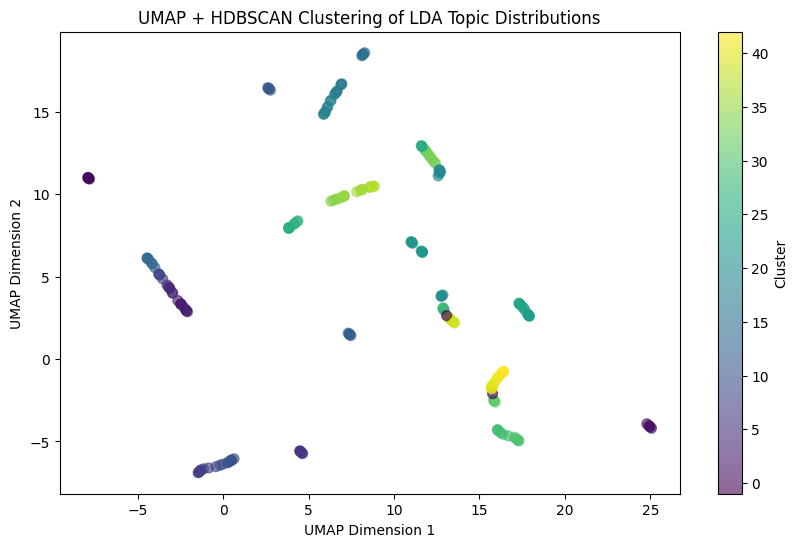

d:\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['breaking', 'current', 'daren', 'events', 'herse', 'himse', 'itse', 'kids', 'mayn', 'mon', 'myse', 'news', 'oughtn', 'pop', 'special', 'stray'] not in stop_words.
  warnings.warn(


Cluster 38: leaf, raw, bridge, recipe, meaning, delicious, rice, add, water, light
Cluster 29: mart, yellow, proper, glennpotz, krw, restaurant, rice, snacks, corridor, vegetables
Cluster 2: manila, recipe, local, city, add, coron, adobo, noman, quail, raining
Cluster 35: fry, manila, recipe, candy, americans, snacks, city, dish, local, adobo
Cluster 26: ice, washy, restaurant, married, visa, ticket, hey, god, dale, mcdonald
Cluster 0: kids, street, americans, rice, delicious, bike, add, water, learn, egg
Cluster 3: arrived, manila, burrito, enter, delicious, lip, rice, water, adobo, heard
Cluster 28: saatin, yoga, phrases, temperature, vegetables, add, water, learn, friends, god
Cluster 18: mad, fried, picture, egg, crazy, short, swimming, beach, understand, day
Cluster 11: breakfast, desire, resident, westside, rice, noodles, class, fallin, egg, wrong
Cluster 12: earlier, nido, apo, instant, pride, noodles, add, embarrassed, water, skin
Cluster 30: theater, ivy, kids, jukgedta, rice,

In [ ]:
import os
import random
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import hdbscan
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'  # Update with your tags folder path

# Load random sample of text files with at least 100 words
def load_random_documents(folder_path, sample_size=200):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))  # Randomly sample files

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()  # Convert text to lowercase while reading
            if len(content.split()) >= 100:  # Only process files with at least 100 words
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]  # Extract video ID from filename
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()  # Read and convert to lowercase
                video_tags[video_id] = tags_content.split()  # Store tags as a list of words
    return video_tags

# Load video tags
video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords from GitHub URL
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    github_stopwords = response.text.splitlines()
    return set(github_stopwords)

# GitHub URL for stopwords
github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya'
]

# Add custom and broad terms
stop_words.update(custom_stop_words, broad_terms, kpop_keywords, more_keywords, github_stopwords)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Helper functions for processing text
def is_valid_word(word, pos):
    unwanted_pattern = re.compile(r'^\s*\[.*\]\s*$', re.IGNORECASE)
    return (
        not re.search(r'(.)\1{2,}', word) and
        word not in stop_words and
        pos not in ['JJ', 'RB', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and
        not unwanted_pattern.match(word)
    )

# Define key phrases to retain as single units
key_phrases = ['fried chicken', 'halo halo', 'kare kare', 'pancit canton', 'ice cream', 'potato fries', 'french fries', 'chicken joy', 'jolly spaghetti']  # Add more as needed

def replace_phrases(text, phrases):
    for phrase in phrases:
        text = text.replace(phrase, phrase.replace(' ', '_'))
    return text

def preprocess_text_with_tags(doc, video_id, video_tags, tag_weight=3):
    doc = replace_phrases(doc.lower(), key_phrases)  # Replace key phrases
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word) for word, pos in tokens_with_pos if word.isalpha() and is_valid_word(word, pos)]
    
    if video_id in video_tags:
        tags = video_tags[video_id]
        tokens += tags * tag_weight
    
    return ' '.join(tokens)

# Array to hold topic vectors for each document
topic_vectors = []

# Process each document for LDA and extract topic distributions
for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")

    preprocessed_doc = preprocess_text_with_tags(doc, video_id, video_tags)
    
    if len(preprocessed_doc) > 0:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([preprocessed_doc])
        
        dictionary = corpora.Dictionary([preprocessed_doc.split()])
        corpus = [dictionary.doc2bow(preprocessed_doc.split())]

        lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=50, random_state=42)

        # Get topic distribution for the document
        topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
        topic_vector = [prob for _, prob in topic_distribution]
        topic_vectors.append(topic_vector)

# Convert topic_vectors to a NumPy array for UMAP and HDBSCAN
topic_vectors = np.array(topic_vectors)

# Step 1: UMAP dimensionality reduction with modified n_neighbors
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=10, random_state=42)
reduced_data = umap_model.fit_transform(topic_vectors)

# Step 2: HDBSCAN clustering with adjusted parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, gen_min_span_tree=True)
clusters = clusterer.fit_predict(reduced_data)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP + HDBSCAN Clustering of LDA Topic Distributions')
plt.show()

# Dictionary to store unique keywords per cluster
unique_cluster_keywords = defaultdict(set)

# Aggregate top keywords for each cluster ensuring uniqueness
if isinstance(stop_words, set):
    stop_words = list(stop_words)
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=10)

for cluster, text in enumerate(documents):
    tfidf_matrix = vectorizer.fit_transform([text])
    terms = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray()[0]
    
    # Collect the top terms for this document
    top_terms = sorted(zip(terms, scores), key=lambda x: x[1], reverse=True)
    
    # Add the unique top terms for this cluster
    for term, score in top_terms:
        if term not in unique_cluster_keywords:
            unique_cluster_keywords[clusters[cluster]].add(term)

# Print top keywords per cluster
for cluster, keywords in unique_cluster_keywords.items():
    print(f"Cluster {cluster}: {', '.join(list(keywords)[:10])}")


Processing file: ifLKnE2WgPE_captions.txt
Processing file: ilvgg0xoqXg_captions.txt
Processing file: 45nukMR5A_c_captions.txt
Processing file: xayG_VtzUIE_captions.txt
Processing file: nM8VDXb7Qog_captions.txt
Processing file: HUaC1mVw7oA_captions.txt
Processing file: FwtwO6lf2aA_captions.txt
Processing file: qGs-DWaJS3I_captions.txt
Processing file: zhTGl8I3Z7Y_captions.txt
Processing file: jSVt-jwgQ1U_captions.txt
Processing file: 2DIqmd6yQBY_captions.txt
Processing file: zCgmAjnTu1o_captions.txt
Processing file: ZKv35nYm5aw_captions.txt
Processing file: AxJ1YGnc1nY_captions.txt
Processing file: tCBSddrRG0E_captions.txt
Processing file: HOCAYxtfSks_captions.txt
Processing file: Z_hNMcayu2A_captions.txt
Processing file: 5ABdJMdZX_s_captions.txt
Processing file: 0-dAyU-yUWk_captions.txt
Processing file: RMk5m8q8rxU_captions.txt
Processing file: G_WEK9DAR9I_captions.txt
Processing file: ToDydz2wCJ0_captions.txt
Processing file: CVx_BaMGkZk_captions.txt
Processing file: j7u0a_WH7hQ_capti

d:\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


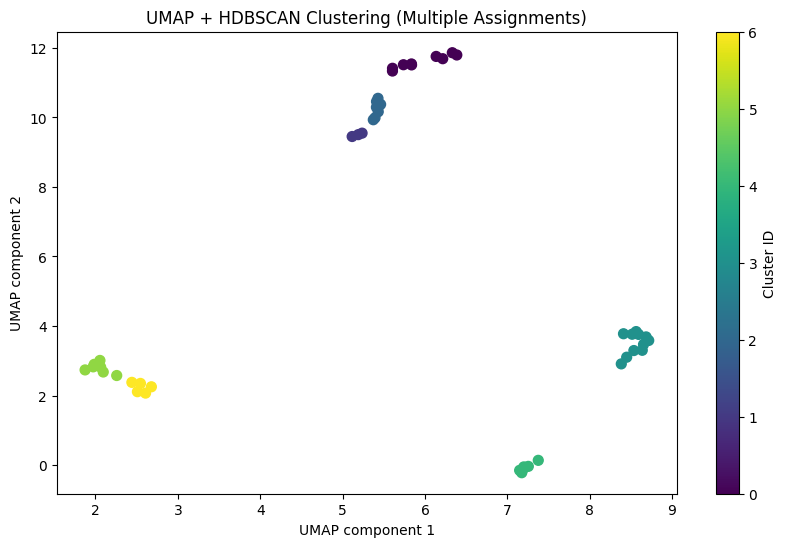

Cluster 0 Top Words: month, grandson, operation, license, rice, production, ton, grace, machine, equipment, operation, grandson, grace, equipment, machine, month, ton, license, production, rice, colleague, grandma, rice, production, license, grandson, ton, grace, equipment, month, month, grandson, operation, license, rice, production, ton, grace, machine, equipment, operation, grandson, grace, equipment, machine, month, ton, license, production, rice, colleague, grandma, rice, production, license, grandson, ton, grace, equipment, month, month, grandson, operation, license, rice, production, ton, grace, machine, equipment, operation, grandson, grace, equipment, machine, month, ton, license, production, rice, colleague, grandma, rice, production, license, grandson, ton, grace, equipment, month, month, grandson, operation, license, rice, production, ton, grace, machine, equipment, operation, grandson, grace, equipment, machine, month, ton, license, production, rice, colleague, grandma, ri

In [15]:
import os
import random
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import hdbscan
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'  # Update with your tags folder path

# Load random sample of text files with at least 100 words
def load_random_documents(folder_path, sample_size=50):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))  # Randomly sample files

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()  # Convert text to lowercase while reading
            if len(content.split()) >= 100:  # Only process files with at least 100 words
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]  # Extract video ID from filename
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()  # Read and convert to lowercase
                video_tags[video_id] = tags_content.split()  # Store tags as a list of words
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords from GitHub URL
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    github_stopwords = response.text.splitlines()
    return set(github_stopwords)

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'city'
]

# Add custom and broad terms
stop_words.update(custom_stop_words, broad_terms, kpop_keywords, more_keywords, github_stopwords)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Helper functions for processing text
def is_valid_word(word, pos):
    unwanted_pattern = re.compile(r'^\s*\[.*\]\s*$', re.IGNORECASE)
    return (
        not re.search(r'(.)\1{2,}', word) and
        word not in stop_words and
        pos not in ['JJ', 'RB', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and
        not unwanted_pattern.match(word)
    )

# Define key phrases to retain as single units
key_phrases = ['fried chicken', 'halo halo', 'kare kare', 'pancit canton', 'ice cream', 'potato fries', 'french fries', 'chicken joy', 'jolly spaghetti']  # Add more as needed

def replace_phrases(text, phrases):
    for phrase in phrases:
        text = text.replace(phrase, phrase.replace(' ', '_'))
    return text

def preprocess_text_with_tags(doc, video_id, video_tags, tag_weight=3):
    doc = replace_phrases(doc.lower(), key_phrases)  # Replace key phrases
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word) for word, pos in tokens_with_pos if word.isalpha() and is_valid_word(word, pos)]
    
    if video_id in video_tags:
        tags = video_tags[video_id]
        tokens += tags * tag_weight
    
    return ' '.join(tokens)

# Array to hold topic vectors for each document
topic_vectors = []

# Process each document for LDA and extract topic distributions
for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")

    preprocessed_doc = preprocess_text_with_tags(doc, video_id, video_tags)
    
    if len(preprocessed_doc) > 0:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([preprocessed_doc])
        
        dictionary = corpora.Dictionary([preprocessed_doc.split()])
        corpus = [dictionary.doc2bow(preprocessed_doc.split())]

        lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=50, random_state=42)

        # Get topic distribution for the document
        topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
        topic_vector = [prob for _, prob in topic_distribution]
        topic_vectors.append(topic_vector)

# Convert topic_vectors to a NumPy array for UMAP and HDBSCAN
topic_vectors = np.array(topic_vectors)

# --- UMAP and HDBSCAN Clustering ---
# UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=10, random_state=42)
reduced_data = umap_model.fit_transform(topic_vectors)

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, gen_min_span_tree=True, allow_single_cluster=False)
clusters = clusterer.fit_predict(reduced_data)

# --- Handle Soft Cluster Assignments ---
soft_cluster_assignments = defaultdict(list)

# Define a threshold for cluster membership probability (e.g., 0.5)
membership_threshold = 0.5

# For each video, check if the probability exceeds the threshold for multiple clusters
for i, video_id in enumerate(file_names):
    prob = clusterer.probabilities_[i]  # Probability for cluster assignment
    if prob >= membership_threshold:
        soft_cluster_assignments[clusterer.labels_[i]].append(video_id)

# --- TOP WORDS FOR EACH CLUSTER ---
def get_top_words_per_cluster(lda_models, num_words=10):
    top_words = {}
    for cluster_id in range(len(set(clusters))):
        words = []
        for lda_model in lda_models:
            for topic_id, topic in lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_words, formatted=False):
                for word, _ in topic:
                    words.append(word)
        top_words[cluster_id] = words
    return top_words

top_words_per_cluster = get_top_words_per_cluster([lda_model for _ in range(len(documents))])

# --- PLOTTING --- 
# Plotting the clustering result with cluster colors
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("UMAP + HDBSCAN Clustering (Multiple Assignments)")
plt.xlabel("UMAP component 1")
plt.ylabel("UMAP component 2")
plt.colorbar(label='Cluster ID')
plt.show()

# Display top words for each cluster
for cluster_id, words in top_words_per_cluster.items():
    print(f"Cluster {cluster_id} Top Words: {', '.join(words)}")
    print("-" * 50)


Processing file: G44IUjZ1vOw_captions.txt
Processing file: jOwLMt8-WQs_captions.txt
Processing file: Bfr7zkTXL9A_captions.txt
Processing file: Hbms3mmZWL4_captions.txt
Processing file: pCxtEYH9I84_captions.txt
Processing file: AQtTuTZyNiA_captions.txt
Processing file: iM43LN5gdgs_captions.txt
Processing file: vZMYvrUw8jc_captions.txt
Processing file: VVh-iUfdHQs_captions.txt
Processing file: VIBpeTBlF4c_captions.txt
Processing file: eTx-r4ZI0Q0_captions.txt
Processing file: XMfnDnulMLo_captions.txt
Processing file: ANpbL70-1VI_captions.txt
Processing file: YWAKuKOG4xU_captions.txt
Processing file: zTcCSyucYqI_captions.txt
Processing file: Rw3TZ9pC6iU_captions.txt
Processing file: TnZN3Ae_A5U_captions.txt
Processing file: wiZfB517o3I_captions.txt
Processing file: OSanouo7f7I_captions.txt
Processing file: 6sECozSy7FY_captions.txt
Processing file: vrwkd3W1lD0_captions.txt
Processing file: f0PA-yr-OHo_captions.txt
Processing file: zpT46etTP6E_captions.txt
Processing file: roCaFODDTbM_capti

d:\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


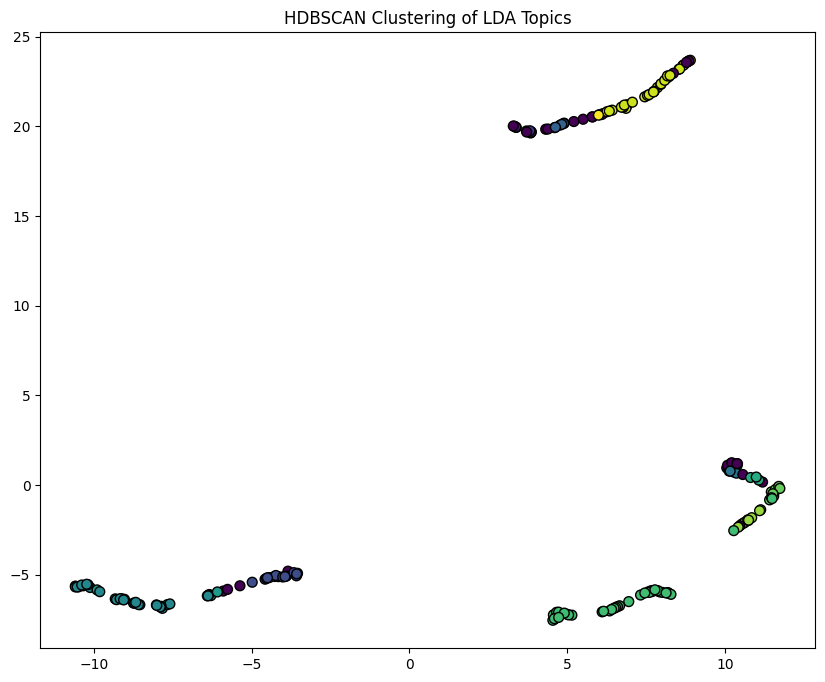


Cluster 9 Top Words: 
  courage (Count: 16)
  chicken (Count: 8)
  dinner (Count: 8)
  kid (Count: 8)
  wing (Count: 8)

Cluster 3 Top Words: 
  courage (Count: 12)
  haircut (Count: 6)
  pass (Count: 6)
  school (Count: 6)
  eat (Count: 6)

Cluster 10 Top Words: 
  courage (Count: 22)
  chicken (Count: 11)
  dinner (Count: 11)
  kid (Count: 11)
  wing (Count: 11)

Cluster 5 Top Words: 
  courage (Count: 68)
  minute (Count: 34)
  taste (Count: 34)
  minister (Count: 34)
  education (Count: 34)

Cluster 0 Top Words: 
  courage (Count: 8)
  haircut (Count: 4)
  pass (Count: 4)
  school (Count: 4)
  eat (Count: 4)

Cluster 8 Top Words: 
  courage (Count: 80)
  chicken (Count: 40)
  dinner (Count: 40)
  kid (Count: 40)
  wing (Count: 40)

Cluster 11 Top Words: 
  courage (Count: 56)
  haircut (Count: 28)
  pass (Count: 28)
  school (Count: 28)
  eat (Count: 28)

Cluster 12 Top Words: 
  courage (Count: 12)
  haircut (Count: 6)
  pass (Count: 6)
  school (Count: 6)
  eat (Count: 6)

Clust

In [29]:
import os
import random
import requests
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'  # Update with your tags folder path

# Function to load random documents (no changes here)
def load_random_documents(folder_path, sample_size=200):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))  # Randomly sample files

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()  # Convert text to lowercase while reading
            if len(content.split()) >= 100:  # Only process files with at least 100 words
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Function to load video tags (no changes here)
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]  # Extract video ID from filename
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()  # Read and convert to lowercase
                video_tags[video_id] = tags_content.split()  # Store tags as a list of words
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Function to fetch stopwords from GitHub URL (no changes here)
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    github_stopwords = response.text.splitlines()  # Split by new lines
    return set(github_stopwords)

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya'
]

# Add custom and broad terms
stop_words.update(custom_stop_words, broad_terms, kpop_keywords, more_keywords, github_stopwords)

# Lemmatizer (no changes here)
lemmatizer = WordNetLemmatizer()

# Function to filter out unwanted words (no changes here)
def is_valid_word(word, pos):
    unwanted_pattern = re.compile(r'^\s*\[.*\]\s*$', re.IGNORECASE)
    return (
        not re.search(r'(.)\1{2,}', word) and
        word not in stop_words and
        pos not in ['JJ', 'RB', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and
        not unwanted_pattern.match(word)
    )

# Preprocessing function including video tags (no changes here)
def preprocess_text_with_tags(doc, video_id, tag_weight=3):
    tokens = word_tokenize(doc.lower())
    tokens_with_pos = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word) for word, pos in tokens_with_pos if word.isalpha() and is_valid_word(word, pos)]
    
    if video_id in video_tags:
        tags = video_tags[video_id]
        tokens += tags * tag_weight  # Repeat tags based on the weight specified
    
    return ' '.join(tokens)

# Store topic vectors (probabilities) for each document
topic_vectors = []
lda_models = []

# Process each document for LDA and store topic distribution
for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")

    preprocessed_doc = preprocess_text_with_tags(doc, video_id)
    
    if len(preprocessed_doc) > 0:
        # Create dictionary and corpus for LDA
        dictionary = corpora.Dictionary([preprocessed_doc.split()])
        corpus = [dictionary.doc2bow(preprocessed_doc.split())]

        # Train LDA model
        lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=50, random_state=42)
        lda_models.append(lda_model)

        # Extract topic distribution for the document
        topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
        topic_vector = [prob for _, prob in topic_distribution]
        topic_vectors.append(topic_vector)

# Convert topic_vectors to NumPy array
topic_vectors = np.array(topic_vectors)

# Step 1: Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_vectors)

# Step 2: Convert cosine similarity to cosine distance
cosine_dist_matrix = 1 - cosine_sim_matrix

# Ensure the cosine distance matrix is of type float64
cosine_dist_matrix = np.float64(cosine_dist_matrix)

# Step 3: UMAP dimensionality reduction on the cosine distance matrix
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
reduced_data = umap_model.fit_transform(cosine_dist_matrix)

# Step 4: HDBSCAN clustering on the reduced data
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=3, metric='precomputed')
clusters = hdbscan_model.fit_predict(cosine_dist_matrix)

# Step 5: Plotting the clustering results
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title("HDBSCAN Clustering of LDA Topics")
plt.show()

def get_top_words_per_cluster(lda_models, cluster_labels, topic_vectors, documents, top_n=5):
    """
    Function to get top words per cluster by counting the most frequent words
    for documents that belong to each cluster.

    Parameters:
    - lda_models: List of trained LDA models.
    - cluster_labels: List of cluster labels for each document.
    - topic_vectors: The topic probability distributions for each document.
    - documents: List of original documents.
    - top_n: The number of top words to display per cluster.
    """
    # Step 1: Store the top words for each topic
    top_words_per_topic = []
    for lda_model in lda_models:
        for topic_id in range(lda_model.num_topics):
            top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
            top_words_per_topic.append(top_words)
    
    # Step 2: Organize the words for each cluster based on document-topic distribution
    cluster_to_words = {}

    for doc_idx, cluster in enumerate(cluster_labels):
        if cluster == -1:  # HDBSCAN's noise points are labeled -1
            continue
        
        # Get the topic distribution for the current document
        topic_dist = topic_vectors[doc_idx]
        
        # Find the top topics for this document
        top_topics = np.argsort(topic_dist)[::-1][:3]  # Get top 3 topics (change if needed)
        
        # Collect words from the top topics of this document
        document_words = []
        for top_topic in top_topics:
            document_words.extend(top_words_per_topic[top_topic])
        
        # Add words to the corresponding cluster
        if cluster not in cluster_to_words:
            cluster_to_words[cluster] = Counter()
        
        # Add words from this document to the cluster's word count
        for word in document_words:
            cluster_to_words[cluster][word] += 1
    
    # Step 3: Display the top words for each cluster
    for cluster, words_count in cluster_to_words.items():
        print(f"\nCluster {cluster} Top Words: ")
        common_words = words_count.most_common(top_n)
        for word, count in common_words:
            print(f"  {word} (Count: {count})")

# Call function to display top words per cluster
get_top_words_per_cluster(lda_models, clusters, topic_vectors, documents)

